In [5]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [6]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import gc

from sklearn.cluster import KMeans
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error as RMSE

from itertools import combinations

import hsilib as hl
hl = reload(hl)

In [7]:
def get_rayleigh_scattering(HSI):
    rayleigh_sig = np.zeros(shape = bands, dtype = HSI.dtype)
    for i in range(bands):
        layer = HSI[..., i]
        rayleigh_sig[i] = layer[layer > 0].min()
        
    return rayleigh_sig

753 1924 187


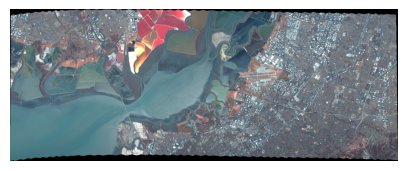

In [8]:
import spectral.io.envi as envi
hsi_path = r'C:\Users\konst\jupyter_notebook\HSI\data envil\moffet\\'
moffett_hsi = envi.open(hsi_path + r'f080611t01p00r07rdn_c_sc01_ort_img.hdr',
                        hsi_path + r'f080611t01p00r07rdn_c_sc01_ort_img')

HSI = np.array(np.rot90(moffett_hsi.open_memmap(writble = True)), dtype = np.float32)
HSI = np.concatenate((HSI[..., :94], HSI[..., 131:]), axis = 2)

height, width, bands = HSI.shape

color_image = hl.HSI_to_RGB(HSI, (37, 18, 11))
print(height, width, bands)
hl.show(color_image, figsize = (5, 5))

In [9]:
reference_coords = np.array(((540,  470),  #0  water
                             (288,  758),  #1  dirt
                             (154,  834),  #2  swamps
                             (315, 1334),  #3  soil
                             (335, 1360),  #4  vegetable
                             (305, 1280),  #5  concrete
                             (278,  606),  #6  salt
                             (18,   811),  #7  salt_water
                             (365, 1431),  #8  asphalt
                             (183, 1208),  #9  lake
                             (707, 1810),  #10 clay
                             (241, 1299),  #11 roof
                             (427, 774),   #12 water2
                             (59, 1098),   #13 lake 2
                             (142, 704),   #14 salt 2
                             (93, 1137)),
                             dtype = int)

name_reference = ("water", "dirt", "swamps", "soil", "vegetable", "concrete", "salt", "salt_water") #, "asphalt", "clay")
name_reference_ru = ("вода", "загрязнения", "болота", "почва", "растительность", "бетон", "соль", "солёная вода", "асфальт", "озёра", "глина", "крыши", "глубокая вода", "озёра 2", "соль 2", 'болота 2')

colors_class = np.array(((0.16, 0.56, 0.56), (0.64, 0.28, 0.64), (0.05, 0.54, 0.13),
                         (0.72, 0.45, 0.2), (0, 0.9, 0), (0.75, 0.75, 0.75),
                         (1, 1, 0), (1, 0, 0), (0.1, 0.1, 1),
                         (0.3, 0.3, 0.3), (1, 0.46, 0.22), (0.95, 0.95, 1),
                         (0.26, 0.70, 0.70), (0.2, 0.2, 0.4), (0.4, 0.1, 0.1),
                         (0.2, 0.4, 0.2)))

In [10]:
rayleigh_scattering = get_rayleigh_scattering(HSI)
HSI -= rayleigh_scattering
HSI[HSI < 0] = 0

In [11]:
hsi_reference = hl.calc_ref(reference_coords, HSI, 1)

In [12]:
imf_reference = hl.EMD(hsi_reference, 4)

#imf_reference = np.concatenate([[hsi_reference], imf_reference], axis = 0)
imf_reference.shape

обработано 16 пикселей из 16

(4, 16, 187)

In [13]:
def SID(s1, s2):    
    s1 = s1 - s1.min() + 1
    s2 = s2 - s2.min() + 1
    
    p = s1 / np.sum(s1)
    q = s2 / np.sum(s2)
    return np.sum((p - q) * (np.log(p) - np.log(q)))

def EVKLID(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)

In [14]:
def do_corr_matrix(vector, metric):
    len_vec = vector.shape[0]
    
    corr_matrix = np.zeros(shape = (len_vec, len_vec), dtype = float)
    
    for j in range(len_vec):
        for k in range(len_vec):
            if j > k:
                continue
            
            correlation = metric(vector[j], vector[k])
            
            corr_matrix[j, k] = correlation
            corr_matrix[k, j] = correlation
            
    return corr_matrix

In [15]:
def show_corr_matrix(corr_matrix, label_axis, title, path = None):    
    fig, ax = plt.subplots(figsize = (7, 7))
    im = ax.imshow(corr_matrix)

    ax.set_xticks(np.arange(len(label_axis)), labels=label_axis, fontsize = 12)
    ax.set_yticks(np.arange(len(label_axis)), labels=label_axis, fontsize = 12)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    for i in range(len(label_axis)):
        for j in range(len(label_axis)):
            text = ax.text(j, i, int(corr_matrix[i, j]),
                           ha="center", va="center", color="w", fontsize = 14)
    
    #ax.set_title(title, fontsize = 16)
    fig.tight_layout()
    
    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close()

In [16]:
def get_pix_combinations(min_combinations, max_combinations, iterable):
    pix_combinations = []
    
    for i in range(min_combinations, max_combinations + 1):
        cmb = combinations(range(iterable), i)
        pix_combinations.extend(list(cmb))
        
    return pix_combinations

In [17]:
def do_clust(imf_reference, pix_combinations, name_reference):
    main_num_classes = imf_reference.shape[1]
    num_class_power = -1
    
#############################################################
    class_stat = dict()
    for i in range(len(name_reference)):
        class_stat[name_reference[i]] = [main_num_classes - 1, 0, 0]
#################################################################
    
    
#################################################################        
    for nc in range(main_num_classes - 1):
        if nc != 0:
            #if num_class_power == -1:
            #    print("плохо дело")
            #    break
                
            imf_reference = np.delete(imf_reference, num_class_power, axis = 1)
            name_reference = np.delete(name_reference, num_class_power)
        
        #tmp = 0
        max_class_power = 0
        num_class_power = -1
        num_combinations_class_power = -1
        num_imf, num_classes, _ = imf_reference.shape
#################################################################
        for i in range(len(pix_combinations)):
            if i % 100 == 0:
                print('\r', end = '')
                print(i, end = '')
                
            
            if num_classes > 2:
            
                composite_reference = np.sum(imf_reference[pix_combinations[i], :], axis = 0) #  sum( ref[combination] ) for all classes, return n_classes x 224
                corr_matrix = do_corr_matrix(composite_reference, EVKLID)
                #corr_matrix = do_corr_matrix(composite_reference, ANGLE)
                
                for k in range(num_classes):
                    other_modul = 0.0
                    #good = False
                    good = True
                    
                    for j in range(num_classes):
                        if j == k:
                            continue
                    
                        other_stat_class = np.delete(corr_matrix[j], (k, j))
                        other_stat_class = other_stat_class.mean()# + (other_stat_class.std() * 1)
                        other_modul = other_modul + other_stat_class ** 2
                    
                        #if corr_matrix[k, j] > other_stat_class:
                        #    good = True
                        #else:
                        #    good = False
                        #    break
                
                    if good:
                        class_power = np.sqrt(np.sum(corr_matrix[k] ** 2)) / np.sqrt(other_modul)
                        if class_power > max_class_power:
                            max_class_power = class_power
                            num_class_power = k
                            num_combinations_class_power = i
                            tmp = corr_matrix[k]
                            
            else:
                
                composite_reference = np.sum(imf_reference[pix_combinations[i], :], axis = 0)
                corr_two_classes = EVKLID(composite_reference[0], composite_reference[1])
                #corr_two_classes = ANGLE(composite_reference[0], composite_reference[1])
                
                if corr_two_classes > max_class_power:
                    max_class_power = corr_two_classes
                    num_class_power = 0
                    num_combinations_class_power = i
                
        class_stat[name_reference[num_class_power]][0] = nc
        class_stat[name_reference[num_class_power]][1] = num_combinations_class_power
        
        
        if num_classes > 2:
            class_stat[name_reference[num_class_power]][2] = np.min(tmp[tmp != 0])
        else:
            class_stat[name_reference[num_class_power]][2] = max_class_power
            
            class_stat[name_reference[num_class_power + 1]][0] = main_num_classes - 1
            class_stat[name_reference[num_class_power + 1]][1] = num_combinations_class_power
            class_stat[name_reference[num_class_power + 1]][2] = max_class_power
                        
#################################################################################################################################################################################################
        print("\nclass_power", max_class_power, name_reference[num_class_power], "imf combinations", pix_combinations[num_combinations_class_power])
        
        print(imf_reference.shape)
        #cr = np.sum(imf_reference[pix_combinations[num_combinations_class_power], :], axis = 0)
        #cm = do_corr_matrix(cr, EVKLID)
        #title = "наисельнейший класс - " + name_reference[num_class_power]
        #path = "./image-data/на-статью/combination-imf+усечение-матрицы/cross-correlation-matrices/" + str(nc + 1) + "-" + name_reference[num_class_power]
        #show_corr_matrix(cm, name_reference, title, path)
        #show_corr_matrix(cm, name_reference, title, None)
        
    return class_stat

In [18]:
def ANGLE(vector1, vector2):
    unit_vector1 = vector1 / np.linalg.norm(vector1)
    unit_vector2 = vector2 / np.linalg.norm(vector2)

    return np.abs(np.dot(unit_vector1, unit_vector2) - 1)

def mul_cos_angles(vector1, vector2):
    unit_vector1 = vector1.transpose() / np.linalg.norm(vector1, axis = 1)
    unit_vector2 = vector2.transpose() / np.linalg.norm(vector2, axis = 1)
    
    unit_vector1 = unit_vector1.transpose()
    unit_vector2 = unit_vector2.transpose()
    
    angles = np.zeros(shape = (unit_vector1.shape[0], unit_vector2.shape[0]))
    for i in range(unit_vector2.shape[0]):
        angles[:, i] = unit_vector1.dot(unit_vector2[i])
        
    return np.abs(angles - 1)

-------------------------

# Load IMFs

In [19]:
_ = gc.collect()
imfs = hl.EMD(HSI, 4)

обработано 1447601 пикселей из 1448772

In [ ]:
#imfs_0_3 = np.load("0-3.npy")
#imfs[0:4, :, :, :] = np.float32(imfs_0_3)
#del imfs_0_3
#_ = gc.collect()
#print("imfs_0_3 loaded")
#
#
#imfs_4_7 = np.load("4-7.npy")
#imfs[4:8, :, :, :] = np.float32(imfs_4_7)
#del imfs_4_7
#_ = gc.collect()
#print("imfs_4_7 loaded")
#
#
#imfs_8_11 = np.load("8-11.npy")
#imfs[8:12, :, :, :] = np.float32(imfs_8_11)
#del imfs_8_11
#_ = gc.collect()
#print("imfs_8_11 loaded")
#
#
#imfs_12_15 = np.load("12-15.npy")
#imfs[12:16, :, :, :] = np.float32(imfs_12_15)
#del imfs_12_15
#_ = gc.collect()
#print("imfs_12_15 loaded")
#
#
#imfs_16_19 = np.load("16-19.npy")
#imfs[16:20, :, :, :] = np.float32(imfs_16_19)
#del imfs_16_19
#_ = gc.collect()
#print("imfs_16_19 loaded")

In [18]:
#del imfs
#_ = gc.collect()

-------------------------

In [20]:
pix_combinations = get_pix_combinations(1, 4, 4)
len(pix_combinations)

15

In [21]:
from time import time

In [22]:
s = time()
class_stat = do_clust(imf_reference, pix_combinations, name_reference_ru)
e = time()
print('t', e - s)

0
class_power 2.8988201969588885 крыши imf combinations (1, 2)
(4, 16, 187)
0
class_power 1.7811540555567074 растительность imf combinations (0,)
(4, 15, 187)
0
class_power 1.859497584377988 соль imf combinations (0,)
(4, 14, 187)
0
class_power 2.123949744380656 почва imf combinations (0,)
(4, 13, 187)
0
class_power 2.1612178456023026 солёная вода imf combinations (3,)
(4, 12, 187)
0
class_power 2.4811332401775994 бетон imf combinations (0, 1)
(4, 11, 187)
0
class_power 2.5686442884698577 глина imf combinations (0,)
(4, 10, 187)
0
class_power 1.5551976320226852 болота imf combinations (0,)
(4, 9, 187)
0
class_power 1.5538332049926737 соль 2 imf combinations (3,)
(4, 8, 187)
0
class_power 1.7489828862068084 озёра imf combinations (3,)
(4, 7, 187)
0
class_power 1.6358730528216423 болота 2 imf combinations (0,)
(4, 6, 187)
0
class_power 1.4786351456871902 озёра 2 imf combinations (0,)
(4, 5, 187)
0
class_power 1.5854419566762015 загрязнения imf combinations (3,)
(4, 4, 187)
0
class_power 

In [23]:
class_stat

{'вода': [14, 14, 129.37561562216655],
 'загрязнения': [12, 3, 39.925853503729215],
 'болота': [7, 0, 240.97717401780758],
 'почва': [3, 0, 499.63277737013306],
 'растительность': [1, 0, 337.3425427938097],
 'бетон': [5, 4, 735.5147457128725],
 'соль': [2, 0, 591.1207750533356],
 'солёная вода': [4, 3, 140.65364651721518],
 'асфальт': [13, 3, 29.941272767922012],
 'озёра': [9, 3, 47.78936327723711],
 'глина': [6, 0, 474.51426170785544],
 'крыши': [0, 7, 789.945024568269],
 'глубокая вода': [15, 14, 129.37561562216655],
 'озёра 2': [11, 0, 120.14620469268955],
 'соль 2': [8, 3, 53.80283487000822],
 'болота 2': [10, 0, 109.8463568133781]}

In [24]:
sorted_value_index = np.array(list(class_stat.values()), dtype = float)
sorted_value_index = np.array(sorted_value_index[:, 0], dtype = int)
sorted_value_index = np.argsort(sorted_value_index)

class_stat = {k: v for k, v in sorted(class_stat.items(), key = lambda item: item[1])}

In [28]:
s = time()

class_mask = np.zeros(shape = (height, width), dtype = int)
class_mask[:, :] = -1
arange = np.arange(imfs.shape[0])
sort_name_reference = list(class_stat.keys())

for i in range(len(sort_name_reference)):
#################################################################
    name = sort_name_reference[i]
    print("name", name)
    num_combinations = class_stat[name][1]
    
    num_imf = pix_combinations[num_combinations]

    print("num_combinations", num_combinations)
    print("num_imf", num_imf)
    
    imf_image = np.sum(imfs[num_imf, :, :, :], axis = 0)
    print("imf_image.shape", imf_image.shape)
    
#################################################################    
    n_class = sorted_value_index[i]
    print("n_class", n_class)
    
    composite_reference = np.sum(imf_reference[num_imf , n_class], axis = 0)
    print("composite_reference", composite_reference.shape)
    
#################################################################
    
    tmp_class_mask = np.linalg.norm(imf_image - composite_reference, axis = 2)
    min_class_corr = class_stat[name][2]
    tmp_class_mask[tmp_class_mask > min_class_corr * 0.25] = 0
    class_mask[(tmp_class_mask != 0) & (class_mask == -1)] = n_class
    
    print("min_class_corr", min_class_corr)
    
    title = "класс №" + str(i + 1) + " - " + name
    #plt.figure(figsize = (20, 8))
    ##plt.title(title)
    #plt.imshow(tmp_class_mask)
    ##plt.colorbar(shrink = 0.3)
    #plt.axis("off")
    #plt.tight_layout()
    #
    ##plt.show()
    #
    #path = "./image-data/на-статью/combination-imf+усечение-матрицы-rr/inter-iteration-division-into-classes/" + title
    #plt.savefig(path)
    #plt.close()
    #
    #print('\n')

    del imf_image
    _ = gc.collect()
    
e = time()
print('t', e - s)

name крыши
num_combinations 7
num_imf (1, 2)
imf_image.shape (753, 1924, 187)
n_class 11
composite_reference (187,)
min_class_corr 789.945024568269
name растительность
num_combinations 0
num_imf (0,)
imf_image.shape (753, 1924, 187)
n_class 4
composite_reference (187,)
min_class_corr 337.3425427938097
name соль
num_combinations 0
num_imf (0,)
imf_image.shape (753, 1924, 187)
n_class 6
composite_reference (187,)
min_class_corr 591.1207750533356
name почва
num_combinations 0
num_imf (0,)
imf_image.shape (753, 1924, 187)
n_class 3
composite_reference (187,)
min_class_corr 499.63277737013306
name солёная вода
num_combinations 3
num_imf (3,)
imf_image.shape (753, 1924, 187)
n_class 7
composite_reference (187,)
min_class_corr 140.65364651721518
name бетон
num_combinations 4
num_imf (0, 1)
imf_image.shape (753, 1924, 187)
n_class 5
composite_reference (187,)
min_class_corr 735.5147457128725
name глина
num_combinations 0
num_imf (0,)
imf_image.shape (753, 1924, 187)
n_class 10
composite_refere

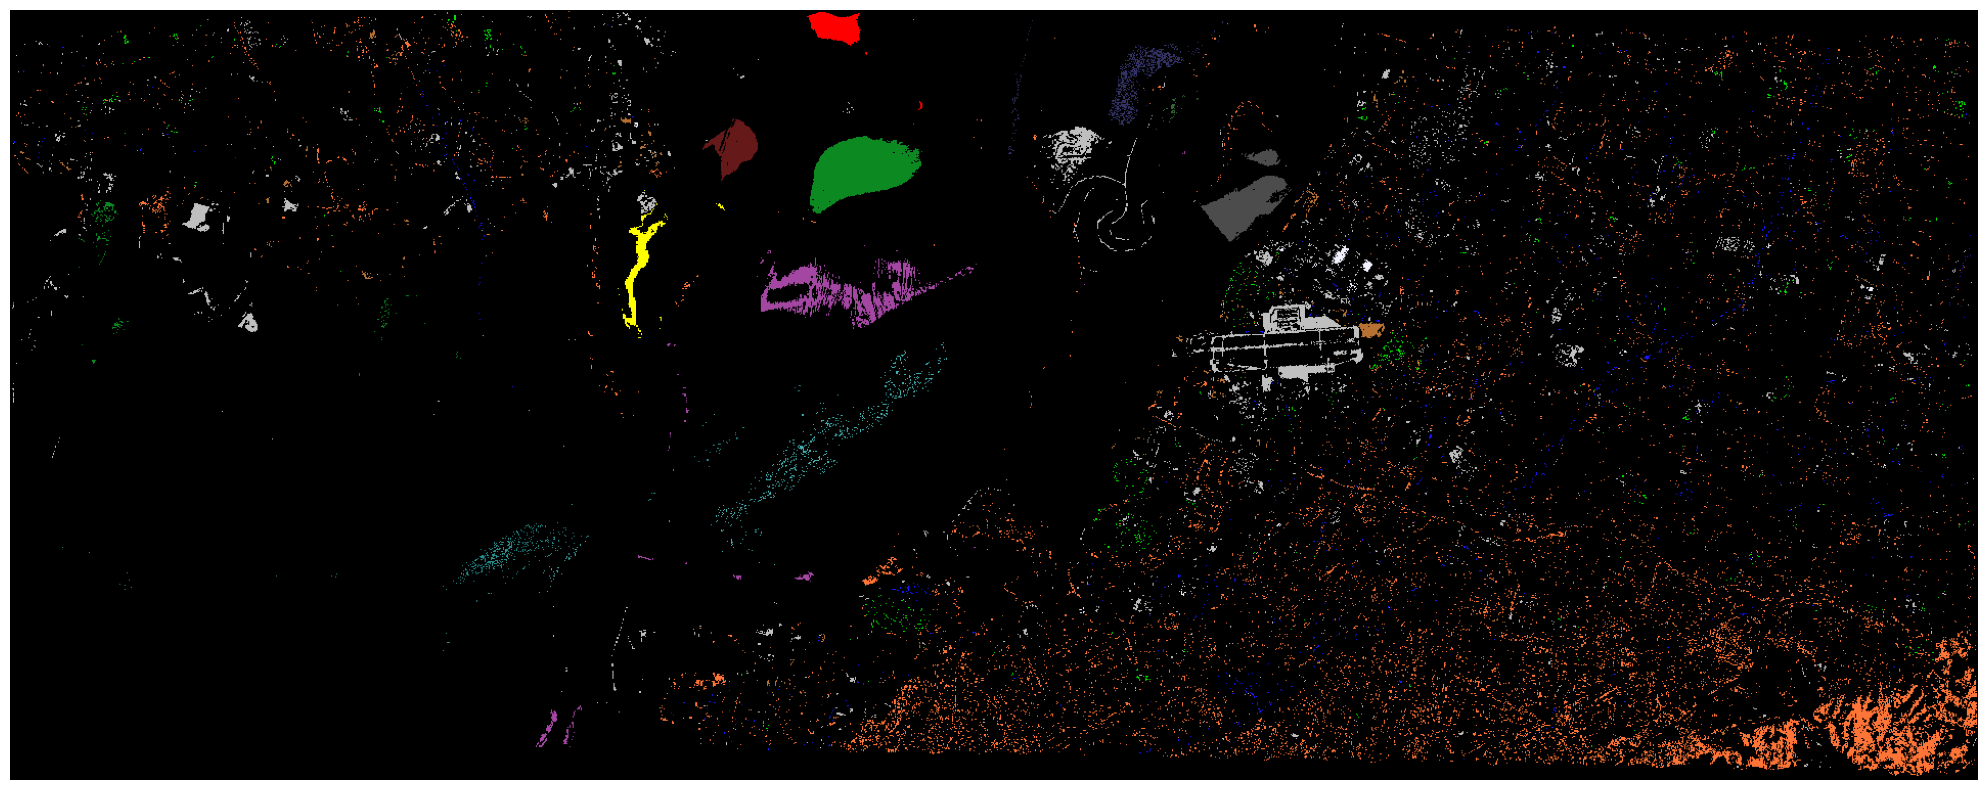

In [29]:
color_class = np.zeros(shape = (height, width, 3), dtype = np.uint8)
for i in range(colors_class.shape[0]):
    color_class[class_mask == i] = np.uint8(colors_class[i] * 255)

non_class_pix = np.zeros(shape = (height, width), dtype = bool)
non_class_pix[class_mask == -1] = True
sum_non_class_pix = np.sum(non_class_pix)
pr = np.float16(sum_non_class_pix / (height * width) * 100)


title = "Контрастная разметка классов. " + str(pr) + "% пикселей не поддались классификации."
plt.figure(figsize = (20, 8))
#plt.title(title, fontsize = 20)
plt.imshow(color_class)
plt.axis("off")
plt.tight_layout()

plt.show()

#path = "./image-data/parade-pictures/IMFs#(0-20)-MinusRayleigh-Сombinations(2-6)-10References-delta0.8/" + title
#plt.savefig(path)
#plt.close()

# natural colors

In [35]:
bool_mask = np.all(HSI == -50, axis = 2)

In [42]:
(100 / (height * width)) * bool_mask[bool_mask].shape[0]

4.716753222729318

In [43]:
height * width - bool_mask[bool_mask].shape[0]

1380437

In [4]:
10945 - 4716

6229

---------------------------------

# OLD